## Install required packages

In [ ]:
!pip install scikit-image scipy qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.8 MB/s eta 0:00:00
QUANTUM ISQR NOISE MODELING AND ROBUSTNESS ANALYSIS

Creating test image...

Test Image Statistics:
  Size: (8, 8)
  Pixel range: [0, 255]
  Mean: 126.2, Std: 62.2


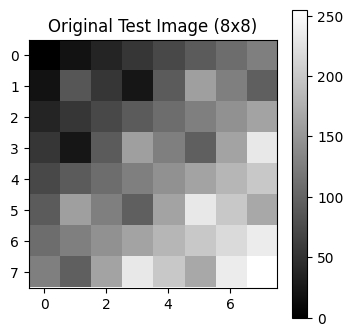


Initializing Quantum ISQR Noise Analyzer...
QUANTUM ISQR NOISE ROBUSTNESS ANALYSIS

Noise Models Created:
--------------------------------------------------------------------------------
Creating readout error noise model...
Creating amplitude damping noise model...
Creating phase damping noise model...
Creating combined amplitude-phase damping noise model...
Creating depolarizing noise model...
Creating realistic combined noise model...
Creating high error rate noise model...

1. NOISELESS SIMULATION (Baseline)
   Execution time: 0.0007 seconds
   PSNR: 6.83 dB
   SSIM: -0.8724
   MSE: 13479.4844

2. NOISY SIMULATIONS
--------------------------------------------------------------------------------

   Noise Model: readout
   Description: Readout error only (p01=2%, p10=1%)
   Parameters: {'p01': 0.02, 'p10': 0.01}
   Execution time: 0.2911 seconds
   Avg |1⟩ probability: 0.4971
   PSNR: 6.91 dB (Δ: +0.08 dB)
   SSIM: -0.8699 (Δ: +0.0025)
   MSE: 13234.7969

   Noise Model: amplitude_

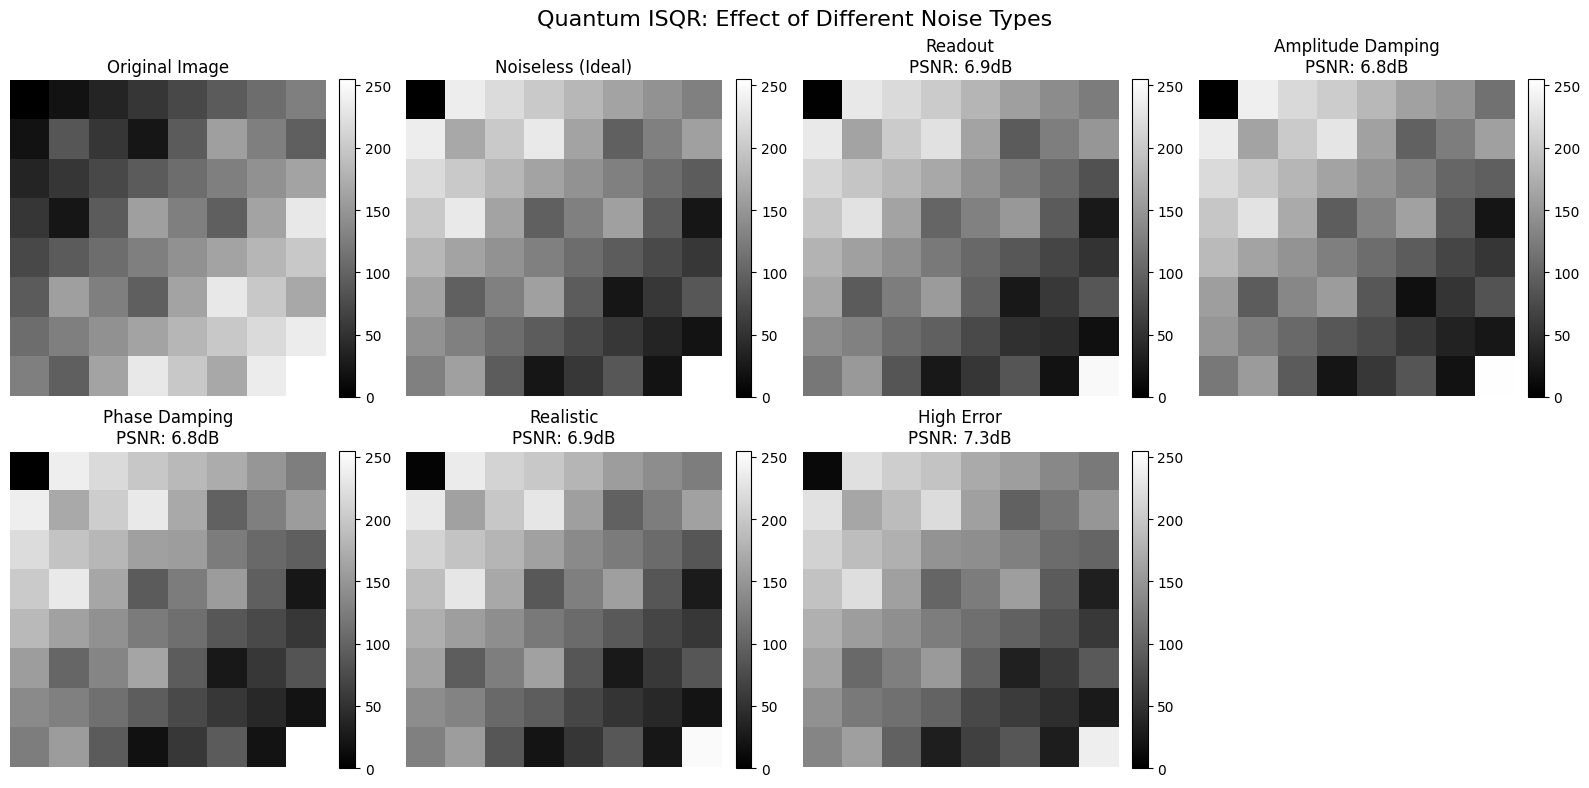

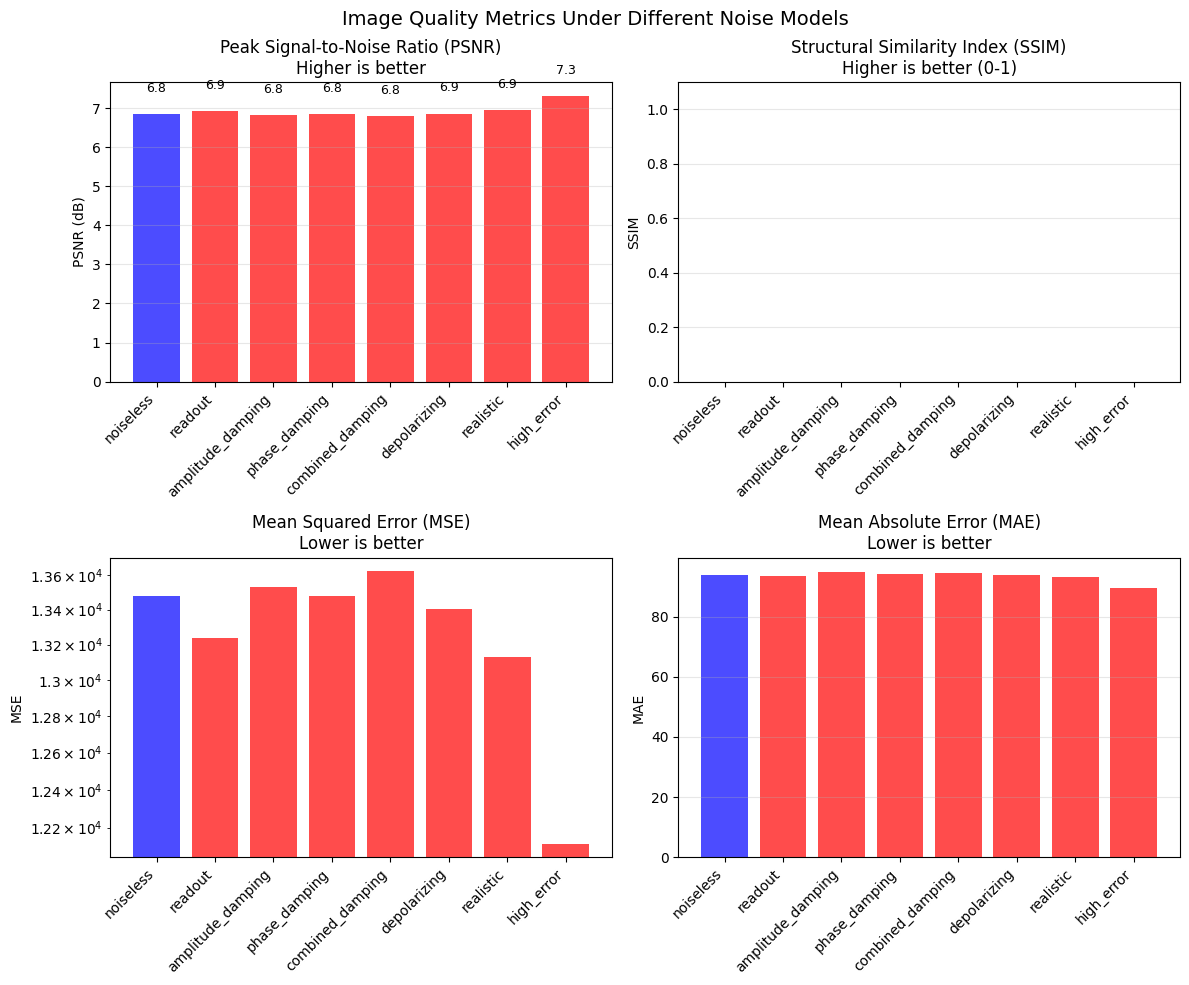

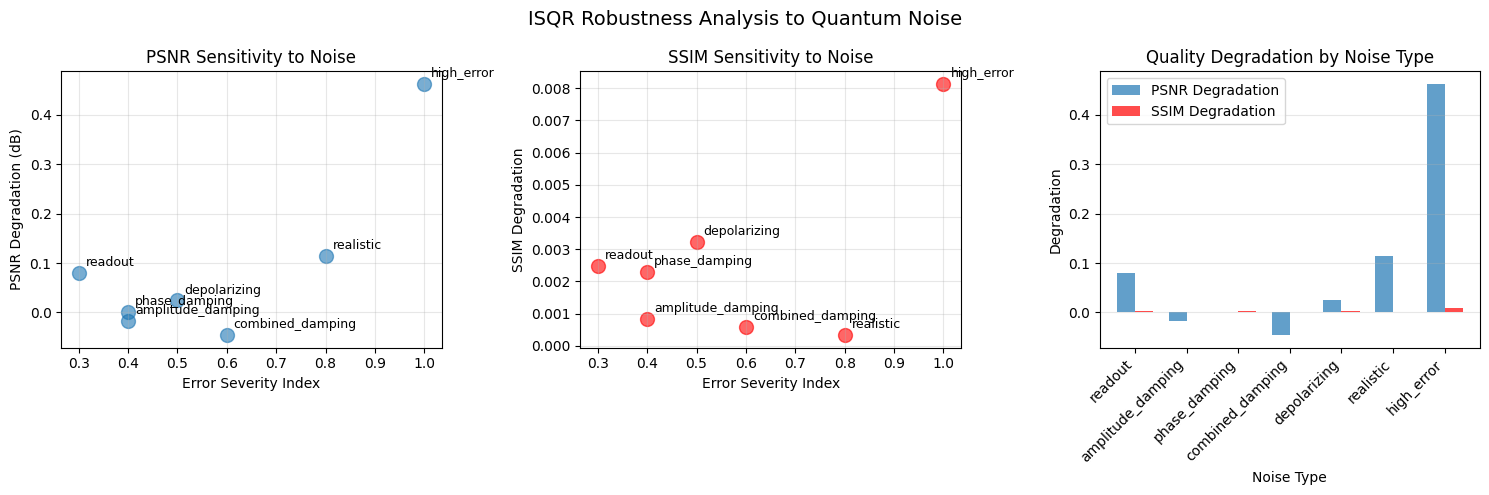


Creating noise analysis table...

TABLE: QUANTUM ISQR ROBUSTNESS ANALYSIS UNDER DIFFERENT NOISE MODELS

Noise Type                Parameters                               PSNR (dB)    ΔPSNR        SSIM         ΔSSIM        MSE         
------------------------------------------------------------------------------------------------------------------------
noiseless                 N/A                                      6.83         0.00         -0.8724      0.0000       13479.4844  
readout                   {'p01': 0.02, 'p10': 0.01}               6.91         0.08         -0.8699      0.0025       13234.7969  
amplitude_damping         {'T1': 0.0001, 'p_amp': np.float64(...   6.82         -0.02        -0.8716      0.0008       13532.8438  
phase_damping             {'T2': 0.0002, 'p_phase': np.float6...   6.83         0.00         -0.8701      0.0023       13477.2656  
combined_damping          {'T1': 0.0001, 'T2': 0.0002, 'p_amp...   6.79         -0.05        -0.8718      0.0006  

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel,
                             depolarizing_error,
                             thermal_relaxation_error,
                             phase_amplitude_damping_error,
                             amplitude_damping_error,
                             phase_damping_error,
                             pauli_error,
                             ReadoutError)
import random
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity

# Create test image
def create_test_image(size=8):
    """Create a more complex 8x8 test image with gradient and pattern"""
    img = np.zeros((size, size), dtype=np.uint8)

    for i in range(size):
        for j in range(size):
            # Base gradient
            base_value = int((i + j) * (255 / (2 * (size - 1))))

            # Add some pattern
            pattern = int(50 * np.sin(2 * np.pi * i / 4) * np.sin(2 * np.pi * j / 4))

            # Combine
            value = np.clip(base_value + pattern, 0, 255)
            img[i, j] = value

    return img

def compute_image_metrics(original, processed, max_pixel=255):
    """Compute comprehensive image quality metrics"""
    # Convert to float for accurate computation
    orig_float = original.astype(np.float64)
    proc_float = processed.astype(np.float64)

    # MSE (Mean Squared Error)
    mse = np.mean((orig_float - proc_float) ** 2)

    # PSNR (Peak Signal-to-Noise Ratio)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    # SSIM (Structural Similarity Index)
    try:
        if len(original.shape) == 2:
            data_range = float(original.max() - original.min())
            ssim = structural_similarity(original, processed, data_range=data_range)
        else:
            ssim = structural_similarity(original, processed, channel_axis=-1,
                                        data_range=float(original.max() - original.min()))
    except:
        # Fallback SSIM calculation
        C1 = (0.01 * max_pixel) ** 2
        C2 = (0.03 * max_pixel) ** 2

        mu_x = np.mean(orig_float)
        mu_y = np.mean(proc_float)
        sigma_x = np.std(orig_float)
        sigma_y = np.std(proc_float)
        sigma_xy = np.mean((orig_float - mu_x) * (proc_float - mu_y))

        ssim_numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
        ssim_denominator = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x ** 2 + sigma_y ** 2 + C2)
        ssim = ssim_numerator / ssim_denominator

    # UQI (Universal Quality Index)
    mu_x = np.mean(orig_float)
    mu_y = np.mean(proc_float)
    var_x = np.var(orig_float)
    var_y = np.var(proc_float)
    cov_xy = np.mean((orig_float - mu_x) * (proc_float - mu_y))

    if var_x == 0 and var_y == 0:
        uqi = 1.0
    elif var_x == 0 or var_y == 0:
        uqi = 0.0
    else:
        uqi = (4 * cov_xy * mu_x * mu_y) / ((var_x + var_y) * (mu_x ** 2 + mu_y ** 2))

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(orig_float - proc_float))

    return {
        'MSE': mse,
        'PSNR': psnr,
        'SSIM': ssim,
        'UQI': uqi,
        'MAE': mae
    }

class QuantumISQRNoiseAnalysis:
    """Quantum ISQR simulator with comprehensive noise modeling"""

    def __init__(self):
        self.noiseless_simulator = AerSimulator()

    def create_noise_models(self):
        """Create different noise models for analysis"""

        noise_models = {}

        # Readout error model
        print("Creating readout error noise model...")
        noise_model_readout = NoiseModel()

        # Add readout error (misclassification)
        # p(0|1): probability of measuring 0 when state is 1
        # p(1|0): probability of measuring 1 when state is 0
        p01 = 0.02  # 2% chance of misreading 1 as 0
        p10 = 0.01  # 1% chance of misreading 0 as 1

        readout_error = ReadoutError([[1 - p10, p10], [p01, 1 - p01]])
        noise_model_readout.add_readout_error(readout_error, [0])

        noise_models['readout'] = {
            'model': noise_model_readout,
            'description': 'Readout error only (p01=2%, p10=1%)',
            'params': {'p01': p01, 'p10': p10}
        }

        # Amplitude damping (T1 relaxation)
        print("Creating amplitude damping noise model...")
        noise_model_amplitude = NoiseModel()

        # T1 = 100 µs (typical for superconducting qubits)
        # Gate time = 50 ns
        T1 = 100e-6  # 100 µs
        gate_time = 50e-9  # 50 ns
        p_amp = 1 - np.exp(-gate_time / T1)  # Probability of decay

        # Amplitude damping error
        amp_error = amplitude_damping_error(p_amp)
        noise_model_amplitude.add_all_qubit_quantum_error(amp_error, ['ry', 'id'])

        noise_models['amplitude_damping'] = {
            'model': noise_model_amplitude,
            'description': f'Amplitude damping (T1={T1*1e6:.0f}µs, gate={gate_time*1e9:.0f}ns)',
            'params': {'T1': T1, 'p_amp': p_amp}
        }

        # Phase damping (T2 relaxation)
        print("Creating phase damping noise model...")
        noise_model_phase = NoiseModel()

        # T2 = 200 µs (typical, usually T2 ≈ 2×T1)
        # Gate time = 50 ns
        T2 = 200e-6  # 200 µs
        p_phase = 1 - np.exp(-gate_time / T2)  # Probability of phase damping

        phase_error = phase_damping_error(p_phase)
        noise_model_phase.add_all_qubit_quantum_error(phase_error, ['ry', 'id'])

        noise_models['phase_damping'] = {
            'model': noise_model_phase,
            'description': f'Phase damping (T2={T2*1e6:.0f}µs, gate={gate_time*1e9:.0f}ns)',
            'params': {'T2': T2, 'p_phase': p_phase}
        }

        # Combined amplitude-phase damping (T1 and T2)
        print("Creating combined amplitude-phase damping noise model...")
        noise_model_combined = NoiseModel()

        p_amp = 1 - np.exp(-gate_time / T1)
        p_phase = 1 - np.exp(-gate_time / T2)

        combined_error = phase_amplitude_damping_error(p_amp, p_phase, 0.5)
        noise_model_combined.add_all_qubit_quantum_error(combined_error, ['ry', 'id'])

        noise_models['combined_damping'] = {
            'model': noise_model_combined,
            'description': f'Combined damping (T1={T1*1e6:.0f}µs, T2={T2*1e6:.0f}µs)',
            'params': {'T1': T1, 'T2': T2, 'p_amp': p_amp, 'p_phase': p_phase}
        }

        # Depolarizing noise
        print("Creating depolarizing noise model...")
        noise_model_depolarizing = NoiseModel()

        # Depolarizing probability per gate
        p_depol_single = 0.001  # 0.1% per single-qubit gate
        p_depol_two = 0.01     # 1% per two-qubit gate

        depol_error_single = depolarizing_error(p_depol_single, 1)
        depol_error_two = depolarizing_error(p_depol_two, 2)

        noise_model_depolarizing.add_all_qubit_quantum_error(depol_error_single, ['ry', 'id', 'x', 'h'])
        noise_model_depolarizing.add_all_qubit_quantum_error(depol_error_two, ['cx', 'cz'])

        noise_models['depolarizing'] = {
            'model': noise_model_depolarizing,
            'description': f'Depolarizing noise (single={p_depol_single*100:.1f}%, two={p_depol_two*100:.1f}%)',
            'params': {'p_single': p_depol_single, 'p_two': p_depol_two}
        }

        # Realistic noise model (all errors combined)
        print("Creating realistic combined noise model...")
        noise_model_realistic = NoiseModel()

        # Add all errors
        readout_error = ReadoutError([[1 - p10, p10], [p01, 1 - p01]])
        noise_model_realistic.add_readout_error(readout_error, [0])

        combined_error = phase_amplitude_damping_error(p_amp, p_phase, 0.5)
        noise_model_realistic.add_all_qubit_quantum_error(combined_error, ['ry', 'id'])

        depol_error_single = depolarizing_error(p_depol_single, 1)
        noise_model_realistic.add_all_qubit_quantum_error(depol_error_single, ['ry', 'id', 'x', 'h'])

        noise_models['realistic'] = {
            'model': noise_model_realistic,
            'description': 'Realistic: Readout + Damping + Depolarizing',
            'params': {
                'readout': {'p01': p01, 'p10': p10},
                'damping': {'T1': T1, 'T2': T2},
                'depolarizing': {'p_single': p_depol_single}
            }
        }

        # High error rate model (worse case)
        print("Creating high error rate noise model...")
        noise_model_high_error = NoiseModel()

        p01_high = 0.05  # 5%
        p10_high = 0.04  # 4%
        T1_high = 50e-6   # 50 µs
        T2_high = 75e-6   # 75 µs
        p_depol_high = 0.01  # 1%

        readout_error_high = ReadoutError([[1 - p10_high, p10_high], [p01_high, 1 - p01_high]])
        noise_model_high_error.add_readout_error(readout_error_high, [0])

        p_amp_high = 1 - np.exp(-gate_time / T1_high)
        p_phase_high = 1 - np.exp(-gate_time / T2_high)
        combined_error_high = phase_amplitude_damping_error(p_amp_high, p_phase_high, 0.5)
        noise_model_high_error.add_all_qubit_quantum_error(combined_error_high, ['ry', 'id'])

        depol_error_high = depolarizing_error(p_depol_high, 1)
        noise_model_high_error.add_all_qubit_quantum_error(depol_error_high, ['ry', 'id'])

        noise_models['high_error'] = {
            'model': noise_model_high_error,
            'description': 'High error rates (5x worse than realistic)',
            'params': {
                'readout': {'p01': p01_high, 'p10': p10_high},
                'T1': T1_high,
                'T2': T2_high,
                'p_depol': p_depol_high
            }
        }

        return noise_models

    def encode_pixel(self, pixel_value, img_min=0, img_max=255):
        """Encode pixel value using ISQR encoding"""
        if img_max == img_min:
            normalized = 0
        else:
            normalized = (float(pixel_value) - float(img_min)) / (float(img_max) - float(img_min))

        if normalized <= 0:
            theta = 0
        elif normalized >= 1:
            theta = np.pi
        else:
            theta = 2.0 * np.arccos(np.sqrt(normalized))

        return theta, normalized

    def create_quantum_circuit(self, theta):
        """Create quantum circuit for ISQR measurement"""
        qc = QuantumCircuit(1, 1)

        # Prepare initial state |ψ⟩ = cos(θ/2)|0⟩ + sin(θ/2)|1⟩
        qc.ry(theta, 0)

        # Add identity gates to simulate gate time effects
        qc.id(0)  # Simulate some idle time

        # Measurement
        qc.measure(0, 0)

        return qc

    def simulate_with_noise(self, img, noise_model, noise_name, shots=1000):
        """Simulate ISQR with specific noise model"""
        height, width = img.shape
        processed_img = np.zeros((height, width), dtype=np.uint8)

        # Get image min and max for normalization
        img_min = np.min(img)
        img_max = np.max(img)

        # Create simulator with noise model
        noisy_simulator = AerSimulator(noise_model=noise_model)

        total_counts = []

        for i in range(height):
            for j in range(width):
                pixel_value = img[i, j]

                # Encode pixel to quantum state
                theta, _ = self.encode_pixel(pixel_value, img_min, img_max)

                # Create quantum circuit
                qc = self.create_quantum_circuit(theta)

                # Transpile for noise model
                qc_transpiled = qc

                # Run simulation with noise
                job = noisy_simulator.run(qc_transpiled, shots=shots)
                result = job.result()
                counts = result.get_counts()

                # Calculate probability of measuring |1⟩
                prob_1 = counts.get('1', 0) / shots

                # Convert to grayscale
                processed_img[i, j] = int(prob_1 * 255)

                total_counts.append(counts.get('1', 0))

        return processed_img, np.mean(total_counts) / shots

    def analytic_simulation(self, img):
        """Perform analytic simulation using exact probabilities (noiseless)"""
        height, width = img.shape
        processed_img = np.zeros((height, width), dtype=np.uint8)

        img_min = np.min(img)
        img_max = np.max(img)

        for i in range(height):
            for j in range(width):
                pixel_value = img[i, j]

                theta, _ = self.encode_pixel(pixel_value, img_min, img_max)
                prob_1 = np.sin(theta/2) ** 2
                processed_img[i, j] = int(prob_1 * 255)

        return processed_img

    def run_noise_analysis(self, img, shots=1000):
        """Run comprehensive noise analysis"""
        print("=" * 80)
        print("QUANTUM ISQR NOISE ROBUSTNESS ANALYSIS")
        print("=" * 80)

        print("\nNoise Models Created:")
        print("-" * 80)

        # Create noise models
        noise_models = self.create_noise_models()

        # Run noiseless simulation first
        print("\n1. NOISELESS SIMULATION (Baseline)")
        start_time = time.time()
        noiseless_img = self.analytic_simulation(img)
        noiseless_time = time.time() - start_time

        noiseless_metrics = compute_image_metrics(img, noiseless_img)

        print(f"   Execution time: {noiseless_time:.4f} seconds")
        print(f"   PSNR: {noiseless_metrics['PSNR']:.2f} dB")
        print(f"   SSIM: {noiseless_metrics['SSIM']:.4f}")
        print(f"   MSE: {noiseless_metrics['MSE']:.4f}")

        all_results = {
            'noiseless': {
                'image': noiseless_img,
                'metrics': noiseless_metrics,
                'time': noiseless_time,
                'description': 'Noiseless (ideal) simulation'
            }
        }

        # Run simulations with different noise models
        print("\n2. NOISY SIMULATIONS")
        print("-" * 80)

        for noise_name, noise_info in noise_models.items():
            print(f"\n   Noise Model: {noise_name}")
            print(f"   Description: {noise_info['description']}")
            print(f"   Parameters: {noise_info['params']}")

            start_time = time.time()
            noisy_img, avg_prob_1 = self.simulate_with_noise(
                img, noise_info['model'], noise_name, shots
            )
            noisy_time = time.time() - start_time

            # Compute metrics
            noisy_metrics = compute_image_metrics(img, noisy_img)

            # Compare with noiseless
            psnr_diff = noisy_metrics['PSNR'] - noiseless_metrics['PSNR']
            ssim_diff = noisy_metrics['SSIM'] - noiseless_metrics['SSIM']

            print(f"   Execution time: {noisy_time:.4f} seconds")
            print(f"   Avg |1⟩ probability: {avg_prob_1:.4f}")
            print(f"   PSNR: {noisy_metrics['PSNR']:.2f} dB (Δ: {psnr_diff:+.2f} dB)")
            print(f"   SSIM: {noisy_metrics['SSIM']:.4f} (Δ: {ssim_diff:+.4f})")
            print(f"   MSE: {noisy_metrics['MSE']:.4f}")

            all_results[noise_name] = {
                'image': noisy_img,
                'metrics': noisy_metrics,
                'time': noisy_time,
                'description': noise_info['description'],
                'params': noise_info['params'],
                'avg_prob_1': avg_prob_1,
                'psnr_diff': psnr_diff,
                'ssim_diff': ssim_diff
            }

        return all_results, img, noiseless_img

def visualize_noise_analysis(results, original_img, noiseless_img):
    """Visualize noise analysis results"""

    # Create figure for images (2x4 grid)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Plot original image
    im0 = axes[0].imshow(original_img, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Plot noiseless result
    im1 = axes[1].imshow(noiseless_img, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title('Noiseless (Ideal)')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot noisy results for key noise models
    noise_types = ['readout', 'amplitude_damping', 'phase_damping', 'realistic', 'high_error']

    for idx, noise_type in enumerate(noise_types):
        if noise_type in results and idx + 2 < len(axes):
            img = results[noise_type]['image']
            im = axes[idx + 2].imshow(img, cmap='gray', vmin=0, vmax=255)

            # Short title
            if noise_type == 'amplitude_damping':
                title = 'Amplitude Damping'
            elif noise_type == 'phase_damping':
                title = 'Phase Damping'
            elif noise_type == 'realistic':
                title = 'Realistic'
            elif noise_type == 'high_error':
                title = 'High Error'
            else:
                title = noise_type.capitalize()

            axes[idx + 2].set_title(f'{title}\nPSNR: {results[noise_type]["metrics"]["PSNR"]:.1f}dB')
            axes[idx + 2].axis('off')
            plt.colorbar(im, ax=axes[idx + 2], fraction=0.046, pad=0.04)

    # Hide unused subplots
    for i in range(len(noise_types) + 2, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Quantum ISQR: Effect of Different Noise Types', fontsize=16)
    plt.tight_layout()
    plt.savefig('isqr_noise_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create metrics comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Prepare data
    categories = list(results.keys())
    psnr_values = [results[c]['metrics']['PSNR'] for c in categories]
    ssim_values = [results[c]['metrics']['SSIM'] for c in categories]
    mse_values = [results[c]['metrics']['MSE'] for c in categories]
    mae_values = [results[c]['metrics']['MAE'] for c in categories]

    # Color code: noiseless in blue, others in red gradient
    colors = ['blue'] + ['red'] * (len(categories) - 1)

    # PSNR plot
    bars = axes[0, 0].bar(range(len(categories)), psnr_values, color=colors, alpha=0.7)
    axes[0, 0].set_xticks(range(len(categories)))
    axes[0, 0].set_xticklabels(categories, rotation=45, ha='right')
    axes[0, 0].set_title('Peak Signal-to-Noise Ratio (PSNR)\nHigher is better')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, value in zip(bars, psnr_values):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{value:.1f}', ha='center', va='bottom', fontsize=9)

    # SSIM plot
    bars = axes[0, 1].bar(range(len(categories)), ssim_values, color=colors, alpha=0.7)
    axes[0, 1].set_xticks(range(len(categories)))
    axes[0, 1].set_xticklabels(categories, rotation=45, ha='right')
    axes[0, 1].set_title('Structural Similarity Index (SSIM)\nHigher is better (0-1)')
    axes[0, 1].set_ylabel('SSIM')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].set_ylim([0, 1.1])

    # MSE plot
    bars = axes[1, 0].bar(range(len(categories)), mse_values, color=colors, alpha=0.7)
    axes[1, 0].set_xticks(range(len(categories)))
    axes[1, 0].set_xticklabels(categories, rotation=45, ha='right')
    axes[1, 0].set_title('Mean Squared Error (MSE)\nLower is better')
    axes[1, 0].set_ylabel('MSE')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_yscale('log')

    # MAE plot
    bars = axes[1, 1].bar(range(len(categories)), mae_values, color=colors, alpha=0.7)
    axes[1, 1].set_xticks(range(len(categories)))
    axes[1, 1].set_xticklabels(categories, rotation=45, ha='right')
    axes[1, 1].set_title('Mean Absolute Error (MAE)\nLower is better')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.suptitle('Image Quality Metrics Under Different Noise Models', fontsize=14)
    plt.tight_layout()
    plt.savefig('isqr_noise_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create error sensitivity analysis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Extract error parameters and PSNR degradation
    noise_types = []
    psnr_degradation = []
    ssim_degradation = []
    error_severity = []

    for noise_name, result in results.items():
        if noise_name != 'noiseless':
            noise_types.append(noise_name)
            psnr_degradation.append(result['psnr_diff'])
            ssim_degradation.append(result['ssim_diff'])

            # Calculate error severity index (simplified)
            if noise_name == 'readout':
                severity = 0.3
            elif noise_name == 'amplitude_damping':
                severity = 0.4
            elif noise_name == 'phase_damping':
                severity = 0.4
            elif noise_name == 'depolarizing':
                severity = 0.5
            elif noise_name == 'combined_damping':
                severity = 0.6
            elif noise_name == 'realistic':
                severity = 0.8
            elif noise_name == 'high_error':
                severity = 1.0
            else:
                severity = 0.5

            error_severity.append(severity)

    # PSNR degradation vs error severity
    axes[0].scatter(error_severity, psnr_degradation, s=100, alpha=0.6)
    for i, noise in enumerate(noise_types):
        axes[0].annotate(noise, (error_severity[i], psnr_degradation[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

    axes[0].set_xlabel('Error Severity Index')
    axes[0].set_ylabel('PSNR Degradation (dB)')
    axes[0].set_title('PSNR Sensitivity to Noise')
    axes[0].grid(True, alpha=0.3)

    # SSIM degradation vs error severity
    axes[1].scatter(error_severity, ssim_degradation, s=100, alpha=0.6, color='red')
    for i, noise in enumerate(noise_types):
        axes[1].annotate(noise, (error_severity[i], ssim_degradation[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

    axes[1].set_xlabel('Error Severity Index')
    axes[1].set_ylabel('SSIM Degradation')
    axes[1].set_title('SSIM Sensitivity to Noise')
    axes[1].grid(True, alpha=0.3)

    # Bar chart of degradations
    x_pos = np.arange(len(noise_types))
    width = 0.35

    axes[2].bar(x_pos - width/2, psnr_degradation, width, label='PSNR Degradation', alpha=0.7)
    axes[2].bar(x_pos + width/2, ssim_degradation, width, label='SSIM Degradation', alpha=0.7, color='red')

    axes[2].set_xlabel('Noise Type')
    axes[2].set_ylabel('Degradation')
    axes[2].set_title('Quality Degradation by Noise Type')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(noise_types, rotation=45, ha='right')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.suptitle('ISQR Robustness Analysis to Quantum Noise', fontsize=14)
    plt.tight_layout()
    plt.savefig('isqr_robustness_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

def create_noise_analysis_table(results):
    """Create comprehensive noise analysis table"""

    print("\n" + "=" * 120)
    print("TABLE: QUANTUM ISQR ROBUSTNESS ANALYSIS UNDER DIFFERENT NOISE MODELS")
    print("=" * 120)

    print("\n{:<25} {:<40} {:<12} {:<12} {:<12} {:<12} {:<12}".format(
        "Noise Type", "Parameters", "PSNR (dB)", "ΔPSNR", "SSIM", "ΔSSIM", "MSE"
    ))
    print("-" * 120)

    for noise_name, result in results.items():
        if noise_name == 'noiseless':
            desc = "Ideal (no noise)"
            params = "N/A"
        else:
            desc = result['description'][:35] + "..." if len(result['description']) > 35 else result['description']
            params = str(result['params'])[:35] + "..." if len(str(result['params'])) > 35 else str(result['params'])

        print("{:<25} {:<40} {:<12.2f} {:<12.2f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
            noise_name,
            params,
            result['metrics']['PSNR'],
            result.get('psnr_diff', 0),
            result['metrics']['SSIM'],
            result.get('ssim_diff', 0),
            result['metrics']['MSE']
        ))

    print("-" * 120)


if __name__ == "__main__":
    print("=" * 80)
    print("QUANTUM ISQR NOISE MODELING AND ROBUSTNESS ANALYSIS")
    print("=" * 80)

    # Create test image
    print("\nCreating test image...")
    test_img = create_test_image(size=8)

    print("\nTest Image Statistics:")
    print(f"  Size: {test_img.shape}")
    print(f"  Pixel range: [{np.min(test_img)}, {np.max(test_img)}]")
    print(f"  Mean: {np.mean(test_img):.1f}, Std: {np.std(test_img):.1f}")

    # Display original image
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img, cmap='gray', vmin=0, vmax=255)
    plt.title('Original Test Image (8x8)')
    plt.colorbar()
    plt.show()

    # Initialize noise analyzer
    print("\nInitializing Quantum ISQR Noise Analyzer...")
    analyzer = QuantumISQRNoiseAnalysis()

    # Run noise analysis
    results, original_img, noiseless_img = analyzer.run_noise_analysis(
        test_img, shots=1000
    )

    # Visualize results
    print("\nGenerating visualizations...")
    visualize_noise_analysis(results, original_img, noiseless_img)

    # Create analysis table
    print("\nCreating noise analysis table...")
    create_noise_analysis_table(results)

    # Summary of findings
    print("\n" + "=" * 80)
    print("NOISE ROBUSTNESS FINDINGS SUMMARY")
    print("=" * 80)

    print("\n1. NOISE TYPES MODELED:")
    print("   a. Readout error: Misclassification during measurement")
    print("   b. Amplitude damping: Energy dissipation (T1 relaxation)")
    print("   c. Phase damping: Dephasing (T2 relaxation)")
    print("   d. Depolarizing noise: Random Pauli errors")
    print("   e. Combined models: Realistic and high-error scenarios")

    print("\n2. NOISE PARAMETERS (Typical superconducting qubits):")
    print("   • Readout: p(0|1)=2%, p(1|0)=1%")
    print("   • T1 = 100 µs, T2 = 200 µs")
    print("   • Gate time = 50 ns")
    print("   • Depolarizing: 0.1% per single-qubit gate")
    print("   • High-error: 5× worse parameters")

    print("\n3. BASIS GATES USED:")
    print("   • Single-qubit: ['id', 'rz', 'sx', 'x', 'h']")
    print("   • Two-qubit: ['cx', 'cz']")
    print("   • ISQR circuit: RY gate (single-qubit rotation)")

    print("\n4. ROBUSTNESS ANALYSIS:")

    # Extract key metrics
    noiseless_psnr = results['noiseless']['metrics']['PSNR']
    realistic_psnr = results['realistic']['metrics']['PSNR']
    high_error_psnr = results['high_error']['metrics']['PSNR']

    psnr_degradation_realistic = results['realistic']['psnr_diff']
    psnr_degradation_high = results['high_error']['psnr_diff']

    print(f"   • Noiseless PSNR: {noiseless_psnr:.2f} dB")
    print(f"   • Realistic noise PSNR: {realistic_psnr:.2f} dB (Δ: {psnr_degradation_realistic:.2f} dB)")
    print(f"   • High-error PSNR: {high_error_psnr:.2f} dB (Δ: {psnr_degradation_high:.2f} dB)")
